# Preprocessing of squat or pushup raw coordinate text files into segmented and normalized reps

In [1]:
#=====[ Import dependencies ]====
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append('/usr/local/lib/python2.7/site-packages')
import pandas as pd
import pickle

# sys.path.append('/Users/admin3/Dropbox/Stanford/Fall-2015/CS221/project/ai_trainer/data')
sys.path.append('../data')
sys.path.append('../data/squat_pushupData_10to20')
sys.path.append('../inference')

#=====[ Import Data ]=====
# import coords1 as cd
import coordKeys as keys
import coordKeysZ as keysZ

#=====[ Import Labels ]======
import labels

%matplotlib inline

# Step 1: Import Data

In [2]:
#=====[ Get labels ]=====
y = labels.labels15
print 'Number of labeled squats: %d' % len(y)

#=====[ Get raw text files that specify x, y, z coordinates for each joint for each frame ]=====
file_to_open =  '../data/raw_data/squat_pushupData_10to20/squatData15.txt'
# file_to_save = '../data/squat_coords/squat17.p'

Number of labeled squats: 10


In [3]:
#=====[ Import data from text file ] =====

#=====[ There are parameters we can use to cut off unclean coordinates from either end of our dataframe. We 
#=====[ manually do this here, but in our full pipeline, we automate this ]=====

front_cut = 0
back_cut = 0

data = []
with open(file_to_open) as f:
    for line in f:
        try:
            data.append([float(x.replace('\r\n','')) for x in line.split(',')])
        except Exception as e:
            print e

#=====[ Put data in data frame, apply front and back cut, and reset index ]=====
df = pd.DataFrame(data, columns=keysZ.columns)
df = df[front_cut:df.shape[0]-back_cut]
df = df.set_index([range(0,df.shape[0])])
df.head()

,SpineBaseX,SpineBaseY,SpineBaseZ,SpineMidX,SpineMidY,SpineMidZ,NeckX,NeckY,NeckZ,HeadX,...,HandTipLeftZ,ThumbLeftX,ThumbLeftY,ThumbLeftZ,HandTipRightX,HandTipRightY,HandTipRightZ,ThumbRightX,ThumbRightY,ThumbRightZ
0,265.634491,147.381866,2.435789,267.625916,97.077461,2.435156,269.568207,47.954849,2.423147,271.306122,...,2.333601,186.901093,13.399338,2.3577,366.993347,18.443680,2.355573,355.600616,26.000671,2.409600
1,266.573822,150.486969,2.389843,267.985504,97.623581,2.422776,269.582092,47.948135,2.424565,271.318207,...,2.323486,193.330139,10.783035,2.3530,361.493866,13.333481,2.341476,350.834473,23.332031,2.416333
2,266.361176,150.339325,2.391255,267.938385,97.650230,2.421918,269.602753,47.956680,2.425042,271.331726,...,2.338408,202.281830,12.572296,2.3770,345.499207,3.171783,2.368620,336.999207,14.614639,2.407308
3,266.166382,150.172852,2.392015,267.862579,97.623375,2.421175,269.601105,47.953171,2.425256,271.346497,...,2.338790,212.000183,6.638565,2.3700,338.544891,2.004532,2.372438,331.751831,14.252655,2.407917
4,266.009949,150.089874,2.392332,267.810699,97.604034,2.420478,269.608704,47.939423,2.425379,271.345886,...,2.344112,211.887634,6.757584,2.3240,329.798889,1.799118,2.379575,327.897949,16.096069,2.409100


# Step 2: Isolate Individual Squats

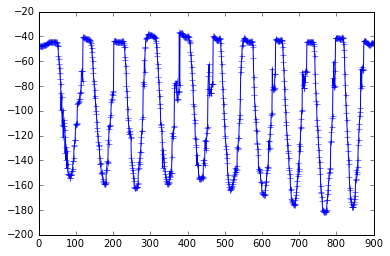

In [4]:
#=====[ Extract y_coords for Neck -- provides a stable point of reference ]=====
y_coords = np.array(df.get('NeckY'))
plt.plot(-y_coords,marker='+')

# Get Max Indices

In [5]:
#=====[ Returns true if the specified index of y_coords is a minimum value ]=====
def is_min(y_coords, height, gradient, index, epsilon, beta):
    if np.abs(y_coords[index] - height)/height < epsilon:
        for i in range(1,beta):
            if gradient[index - i] > 0 or gradient[index + i - 1] < 0:
                return False
        return True
        
#=====[ Returns true if we suspect that we are in a new repetition ]=====
def in_new_squat(y_coords, height, index, delta):
    return abs((y_coords[index] - height)/height) > delta

#=====[ Gets local maxes within accepted epsilon of global max and with max len(y_coors)/gamma maxes ]=====
#=====[ For squats: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.5, beta ~ 1 ]=====
#=====[ For pushups: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.2, beta ~ 1 ]=====

def get_local_mins(y_coords, epsilon=0.25, gamma=50, delta=0.5, beta=2):
    
    local_mins = []
    height = np.min(y_coords[len(y_coords)/3:len(y_coords)*2/3])
    gradient = np.gradient(y_coords)
    
    #=====[ Checks gradients to make sure we are looking at a local min ]=====
    min_located = False
    for index, dy in enumerate(gradient[2:]):
        if(min_located):
            if in_new_squat(y_coords, height, index, delta):
                min_located = False       
            else:
                continue
                
        if  is_min(y_coords, height, gradient, index, epsilon, beta + 1):
            local_mins.append(index)
            min_located = True
        
    return sorted(local_mins)

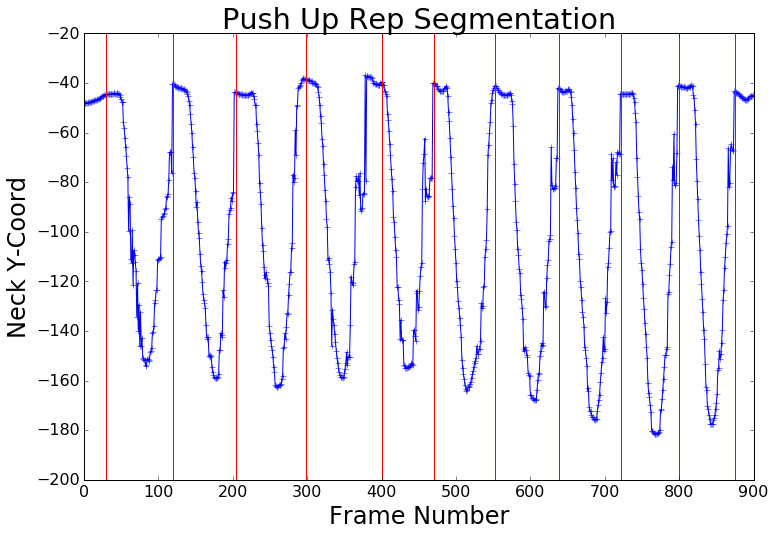

In [6]:
#=====[ Get maxes and plot with y_coords ]=====
mins = get_local_mins(y_coords)
plt.plot(-y_coords,marker='+')

for divide in mins:
    plt.axvline(divide,color='r')

#=====[ Add plot decorations ]=====    
plt.ylabel('Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Push Up Rep Segmentation')
plt.savefig('pushup_separation.png',dpi=200)

# Separate Exercise based on max points found

In [7]:
reps = []

#=====[ Get points from DF between each max found -- constitutes a single squat ]=====
for index,x in enumerate(mins):
    if(index == len(mins) -1 ):
        continue
    rep = (df.loc[x:mins[index+1]-1]).copy(True)
    reps.append(rep.set_index([range(rep.shape[0])]))

print "%d reps extracted, %d labels exracted" % (len(reps), len(y))

10 reps extracted, 10 labels exracted


# Step 3: Normalize Coordinates

In [8]:
# =====[ Helper Functions for getting normalizing parameters ]=====
def y_upper_bound(df):
    return np.min(df['HeadY'])

def y_lower_bound(df):
    return np.median(pd.concat([df['FootRightY'],df['FootLeftY']],axis =0))

def x_zero(df):
    return np.median(df['SpineMidX'])

def z_zero(df):
    return np.median(np.concatenate([df.get('FootLeftZ'),df.get('FootRightZ')],axis=0))

def scaling_factor(df):
    return np.abs(y_upper_bound(df) - y_lower_bound(df))

In [9]:
def normalize(df, reps, z_coords=False):
    
    #=====[ Normalizing constants for the entire set of exercises ]=====
    y_head = y_upper_bound(df)
    scale = scaling_factor(df)
    x_midpoint = x_zero(df)
    z_midpoint = z_zero(df)
    
    for rep in reps:
        
        #=====[ Even columns are x-coordinates, odd columns are y-coordinates -- normalize respectively ]=====
        for index, col in enumerate(rep.columns):
            if index % 3 == 2:
                rep[col] = rep[col].apply((lambda z: ((z - z_midpoint)/scale)))
            elif index % 3 == 1:
                rep[col] = rep[col].apply((lambda y: ((y - y_head)/scale)))
            else:
                rep[col] = rep[col].apply(lambda x: ((x - x_midpoint)/scale))                    

In [10]:
#=====[ Normalize squats: ensure z_coords is set to true if extracting 3-d coordinates ]=====
# from pu_normalization import normalize #<--- This line is used if preprocessing pushups

normalize(df, reps)

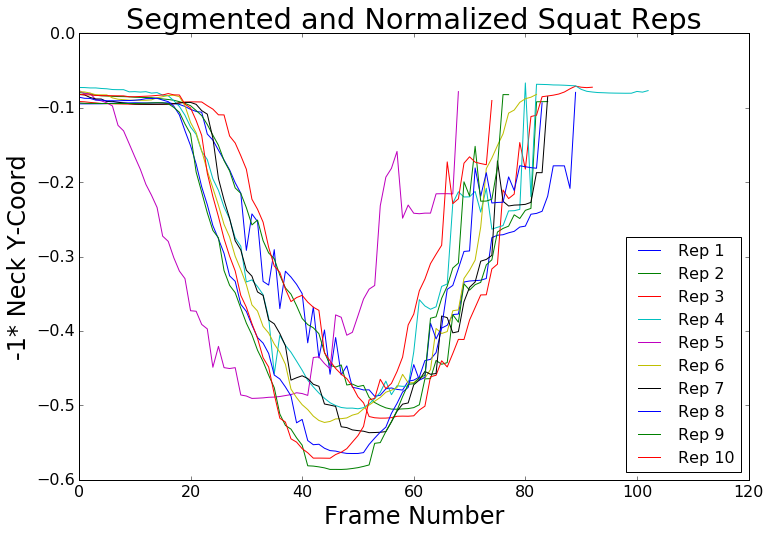

In [11]:
#=====[ Visual comparison between reps ]=====
for index, rep in enumerate(reps):
    plt.plot(-rep.get('NeckY'),label="Rep " + str(index + 1))
plt.legend(loc='lower right', prop={'size':16})
plt.ylabel('-1* Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Segmented and Normalized Squat Reps')

# Compress reps and labels into a pickle file

In [12]:
training_data = []

#=====[ Append label to our squats and pickle the (x,y) pairs ]=====
for index, rep in enumerate(reps):
    training_data.append((rep,y[index]))

In [105]:
#=====[ Save squats in pickle file if desired ]=====
pickle.dump(training_data,open(file_to_save,'wb'))

# Visualize Scaled Body

In [13]:
def plotBody(df,frame):
    coords = np.array(df.loc[frame])
    xs = [coords[i] for i in range(0,coords.size) if i % 3 == 0]
    ys = [-1*coords[i] for i in range(0,coords.size) if i % 3 == 1]    
    zs = [coords[i] for i in range(0,coords.size) if i % 3 == 2]
    plt.plot(xs,ys,linestyle='None',marker='o',markersize=10)
    figure = plt.gcf()
    plt.axis([-.3, .3, -1.1, 0.1])
    figure.set_size_inches(5,8)


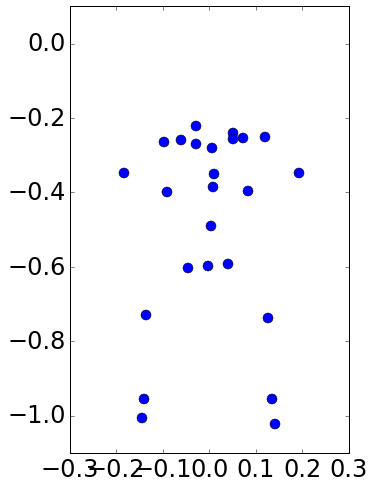

In [14]:
plotBody(reps[1],38)